In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
import sklearn.metrics

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [39]:
folder_dir =  'data/'
#folder_dir =  '../data/'
data_path = "data_clean.csv"
data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
data=data.drop('Unnamed: 0',axis=1)

#=data.head(500)

In [40]:
data.shape

(3878118, 25)

In [41]:
data.isnull().any()[data.isnull().any()]

outcome    True
nasty      True
dtype: bool

In [42]:
### Create features
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'zone',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed'],
      dtype='object')

### Generate distance,speed diff, catgorize pitch type

In [43]:
data['dist']=np.sqrt(data['px']**2+data['pz']**2)
data['speed_diff']=data['rolling_start_speed']-data['long_rolling_start_speed']

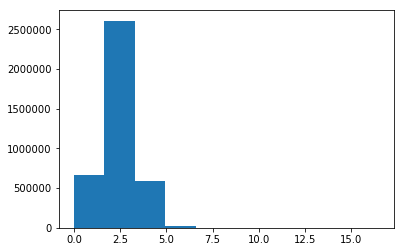

In [44]:
plt.hist(data['dist']);

In [45]:
data['pitch_type'].unique()

array(['FF', 'FS', 'SL', 'CU', 'CH', 'FC', 'KC', 'FT', 'SI'], dtype=object)

In [46]:
#a0.to_numeric(data['pitch_type'],errors='coerce')

In [47]:
pitch_types=pd.get_dummies(data['pitch_type'],prefix='pitch_type')
data=pd.concat([data,pitch_types],axis=1)
pitch_types=0

In [48]:
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'zone',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed', 'dist', 'speed_diff', 'pitch_type_CH',
       'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS',
       'pitch_type_FT', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL'],
      dtype='object')

# Only good zone

In [72]:
data_new = data.loc[data['px'] >= -1]
data_new = data_new.loc[data_new['px'] <= 1]
data_new = data_new.loc[data_new['pz'] >= 1.5]
data_new = data_new.loc[data_new['pz'] <= 3.5]

In [73]:
majority_class=np.amax(data_new['y'].value_counts(normalize=True))
majority_class

0.79003465603963163

## Train, test, validation split

In [51]:
#model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir','pitch_count','balls','strikes','date',
#             'y','rolling_start_speed']

model_feats=['start_speed','spin_dir','pitch_count','balls','strikes','date',
             'y','speed_diff','pitch_type_CH', 'pitch_type_CU','pitch_type_FC', 'pitch_type_FF', 
             'pitch_type_FS', 'pitch_type_FT', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
#model_feats=['px','pz','pfx_x','pfx_z','y','strikes','date']
#y=data['y']
#data=data[model_feats]

In [52]:
data_new["date"] = pd.to_datetime(data_new["date"])

start = data_new["date"].searchsorted(datetime.datetime(2012, 1, 1))[0]
#start
end = data_new["date"].searchsorted(datetime.datetime(2016, 1, 1))[0] - 1
#end

X_train = data_new[model_feats].loc[start:end]
y_train=X_train['y']
X_train=X_train.drop(['y','date'],axis=1)

X_test=data_new[model_feats][end:]
y_test=X_test['y']
X_test=X_test.drop(['y','date'],axis=1)

### Random Forest

In [53]:
steps= [('rf', RandomForestClassifier(oob_score=True))]

mypipeline= Pipeline(steps)

param_grid_rf = dict(
    #rf__min_samples_leaf= np.logspace(4, 5, num=5, base=4, endpoint=False, dtype=int),
    #rf__min_samples_split= [100, 1000],
    rf__max_depth= [8],
    rf__n_estimators=[10]
      )

In [54]:
rf_grid_search= GridSearchCV(mypipeline, 
                             param_grid = param_grid_rf, 
                             scoring = 'neg_log_loss',
                                    n_jobs=-1, refit=True)

rf_grid_search.fit(X_train, y_train)

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sk

GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rf__max_depth': [8], 'rf__n_estimators': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [55]:
best_1 = rf_grid_search.best_score_
print(best_1)
rf_grid_search.best_estimator_
model=rf_grid_search.best_estimator_.steps[0][1]
print(model)

-0.512394190794
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [56]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.3f, %s: %0.3f, %s: %0.3f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,'Majority class',majority_class))

Model accuracy: 0.772, Model log loss: 0.538, Majority class: 0.772 


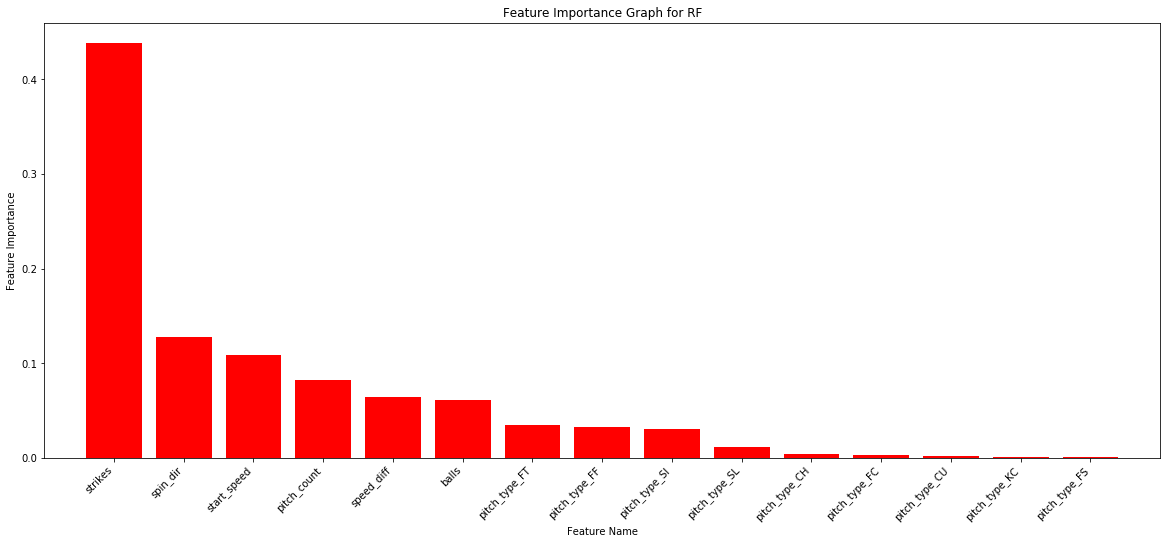

In [57]:
# RF Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig = plt.figure(figsize=(20,8))
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.title('Feature Importances Bar Plot')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=45, horizontalalignment='right')
plt.xlim([-1, len(indices)])
plt.title('Feature Importance Graph for RF')
plt.show()